- Reduced dataframe memory usage
- Handeling missing values
- Exploratory Data Analysis
- Train-test split using Startified
- Handeling Imbalance classes using SMOTE
- Handeling categorical features

  - Ensured train test features and target have same distribution
- Hyperparameter tunning
- Pipeline
- Explainability of particular sample using SHAP and LIME

# Importing Libraries


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier  
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from lime.lime_tabular import LimeTabularExplainer
import shap
shap.initjs()
import warnings
warnings.filterwarnings("ignore")

# Loading data

In [2]:
data = pd.read_csv('../input/credit-card/application_data.csv')
des = pd.read_csv("/kaggle/input/credit-card/columns_description.csv", encoding='latin1')
df = data.copy()

In [3]:
# des

In [4]:
df.shape

(307511, 122)

In [5]:
df.sample(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
200806      332770       0         Cash loans           F            Y   
279070      423306       0         Cash loans           M            Y   
284789      429821       0         Cash loans           F            N   
239067      376907       0         Cash loans           F            N   
82056       195159       0    Revolving loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
200806               Y             0          202500.0    360000.0   
279070               N             0          112500.0    673875.0   
284789               N             0          144000.0    900000.0   
239067               N             1          126000.0    312840.0   
82056                Y             2          225000.0    540000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
200806      23004.0  ...                 0                0                0   
279070      21865.5  ...                 0                0                0   
284789      26316.0  ...                 0                0                0   
239067      24844.5  ...                 0                0                0   
82056       27000.0  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
200806                0                        0.0                       0.0   
279070                0                        0.0                       0.0   
284789                0                        0.0                       0.0   
239067                0                        0.0                       0.0   
82056                 0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
200806                         0.0                        0.0   
279070                         0.0                        0.0   
284789                         0.0                        0.0   
239067                         0.0                        0.0   
82056                          0.0                       14.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
200806                        0.0                         4.0  
279070                        0.0                         1.0  
284789                        0.0                         1.0  
239067                        0.0                         1.0  
82056                         0.0                         0.0  

[5 rows x 122 columns]

In [6]:
# Memory used by df in MB
df.memory_usage().sum()/1024**2

286.2270965576172

In [7]:
def reduce_memory_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')
    return df
data = reduce_memory_usage(data)
df = reduce_memory_usage(df)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float16(61), float32(4), int16(2), int32(2), int8(37), object(16)
memory usage: 92.4+ MB


# Train-test split
- Doing train-test split before EDA as we don't want any information leakage from test data which will afffect our model selection process.

In [66]:
X = df.drop(['TARGET', 'SK_ID_CURR'],axis = 1)
y = df['TARGET'].astype("category")

In [57]:
X_train, X_test, _ , _ = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Converting back to the dataframe
def np_to_df(np, cols_of):
    return pd.DataFrame(np, columns=cols_of.columns)

X_train = np_to_df(X_train, X)
X_test = np_to_df(X_test, X)

In [58]:
cat_cols = list(X_train.select_dtypes('object').columns)
int_cols = list(X_train.select_dtypes(['int8', 'int16', 'int32']).columns)
float_cols = list(X_train.select_dtypes(['float16','float32']).columns)
num_cols = int_cols + float_cols

In [67]:
X_train = pd.concat([X_train[num_cols], X_train[cat_cols]], axis = 1)
X_test = pd.concat([X_test[num_cols], X_test[cat_cols]], axis = 1)

# Exploratory Data Analysis

### Object types

In [59]:
len(cat_cols), len(int_cols), len(float_cols)

(16, 39, 65)

## Analysing numerical columns

In [60]:
X_train[num_cols].agg(['count','min', 'max','mad','mean','median','quantile','kurt','skew','var','std'])

CNT_CHILDREN    DAYS_BIRTH  DAYS_EMPLOYED  DAYS_ID_PUBLISH  \
count     246008.000000  2.460080e+05   2.460080e+05     2.460080e+05   
min            0.000000 -2.522900e+04  -1.791200e+04    -7.197000e+03   
max           19.000000 -7.489000e+03   3.652430e+05     0.000000e+00   
mad            0.583062  3.727230e+03   1.082587e+05     1.315158e+03   
mean           0.416409 -1.602952e+04   6.358116e+04    -2.994150e+03   
median         0.000000 -1.574400e+04  -1.215000e+03    -3.255000e+03   
quantile       0.000000 -1.574400e+04  -1.215000e+03    -3.255000e+03   
kurt           6.245768 -1.048875e+00   7.902941e-01    -1.105477e+00   
skew           1.910168 -1.158239e-01   1.669945e+00     3.490972e-01   
var            0.517681  1.903463e+07   1.990405e+10     2.274892e+06   
std            0.719500  4.362869e+03   1.410817e+05     1.508275e+03   

             FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
count     246008.000000   246008.000000    246008.000000     246008.000000   
min            0.000000        0.000000         0.000000          0.000000   
max            1.000000        1.000000         1.000000          1.000000   
mad            0.000008        0.294536         0.319616          0.003749   
mean           0.999996        0.820518         0.199680          0.998122   
median         1.000000        1.000000         0.000000          1.000000   
quantile       1.000000        1.000000         0.000000          1.000000   
kurt      246008.000000        0.790373         0.257531        527.497475   
skew        -495.991935       -1.670439         1.502508        -23.010719   
var            0.000004        0.147269         0.159809          0.001874   
std            0.002016        0.383756         0.399761          0.043295   

             FLAG_PHONE     FLAG_EMAIL  ...  DEF_30_CNT_SOCIAL_CIRCLE  \
count     246008.000000  246008.000000  ...             245197.000000   
min            0.000000       0.000000  ...                  0.000000   
max            1.000000       1.000000  ...                 34.000000   
mad            0.404027       0.107030  ...                  0.253906   
mean           0.280942       0.056734  ...                  0.143555   
median         0.000000       0.000000  ...                  0.000000   
quantile       0.000000       0.000000  ...                  0.000000   
kurt          -1.049836      12.686566  ...                       NaN   
skew           0.974768       3.832292  ...                       NaN   
var            0.202014       0.053515  ...                  0.200684   
std            0.449460       0.231334  ...                  0.447998   

          OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
count                     245197.0             245197.000000   
min                            0.0                  0.000000   
max                          344.0                 24.000000   
mad                            NaN                  0.182739   
mean                           NaN                  0.099548   
median                         0.0                  0.000000   
quantile                       0.0                  0.000000   
kurt                           NaN                       NaN   
skew                           NaN                       NaN   
var                            NaN                  0.130859   
std                            NaN                  0.361816   

          DAYS_LAST_PHONE_CHANGE  AMT_REQ_CREDIT_BUREAU_HOUR  \
count                   246007.0               212764.000000   
min                      -4292.0                    0.000000   
max                          0.0                    4.000000   
mad                          NaN                    0.012512   
mean                         NaN                    0.006290   
median                    -757.0                    0.000000   
quantile                  -757.0                    0.000000   
kurt                         NaN       

### Variable distributions

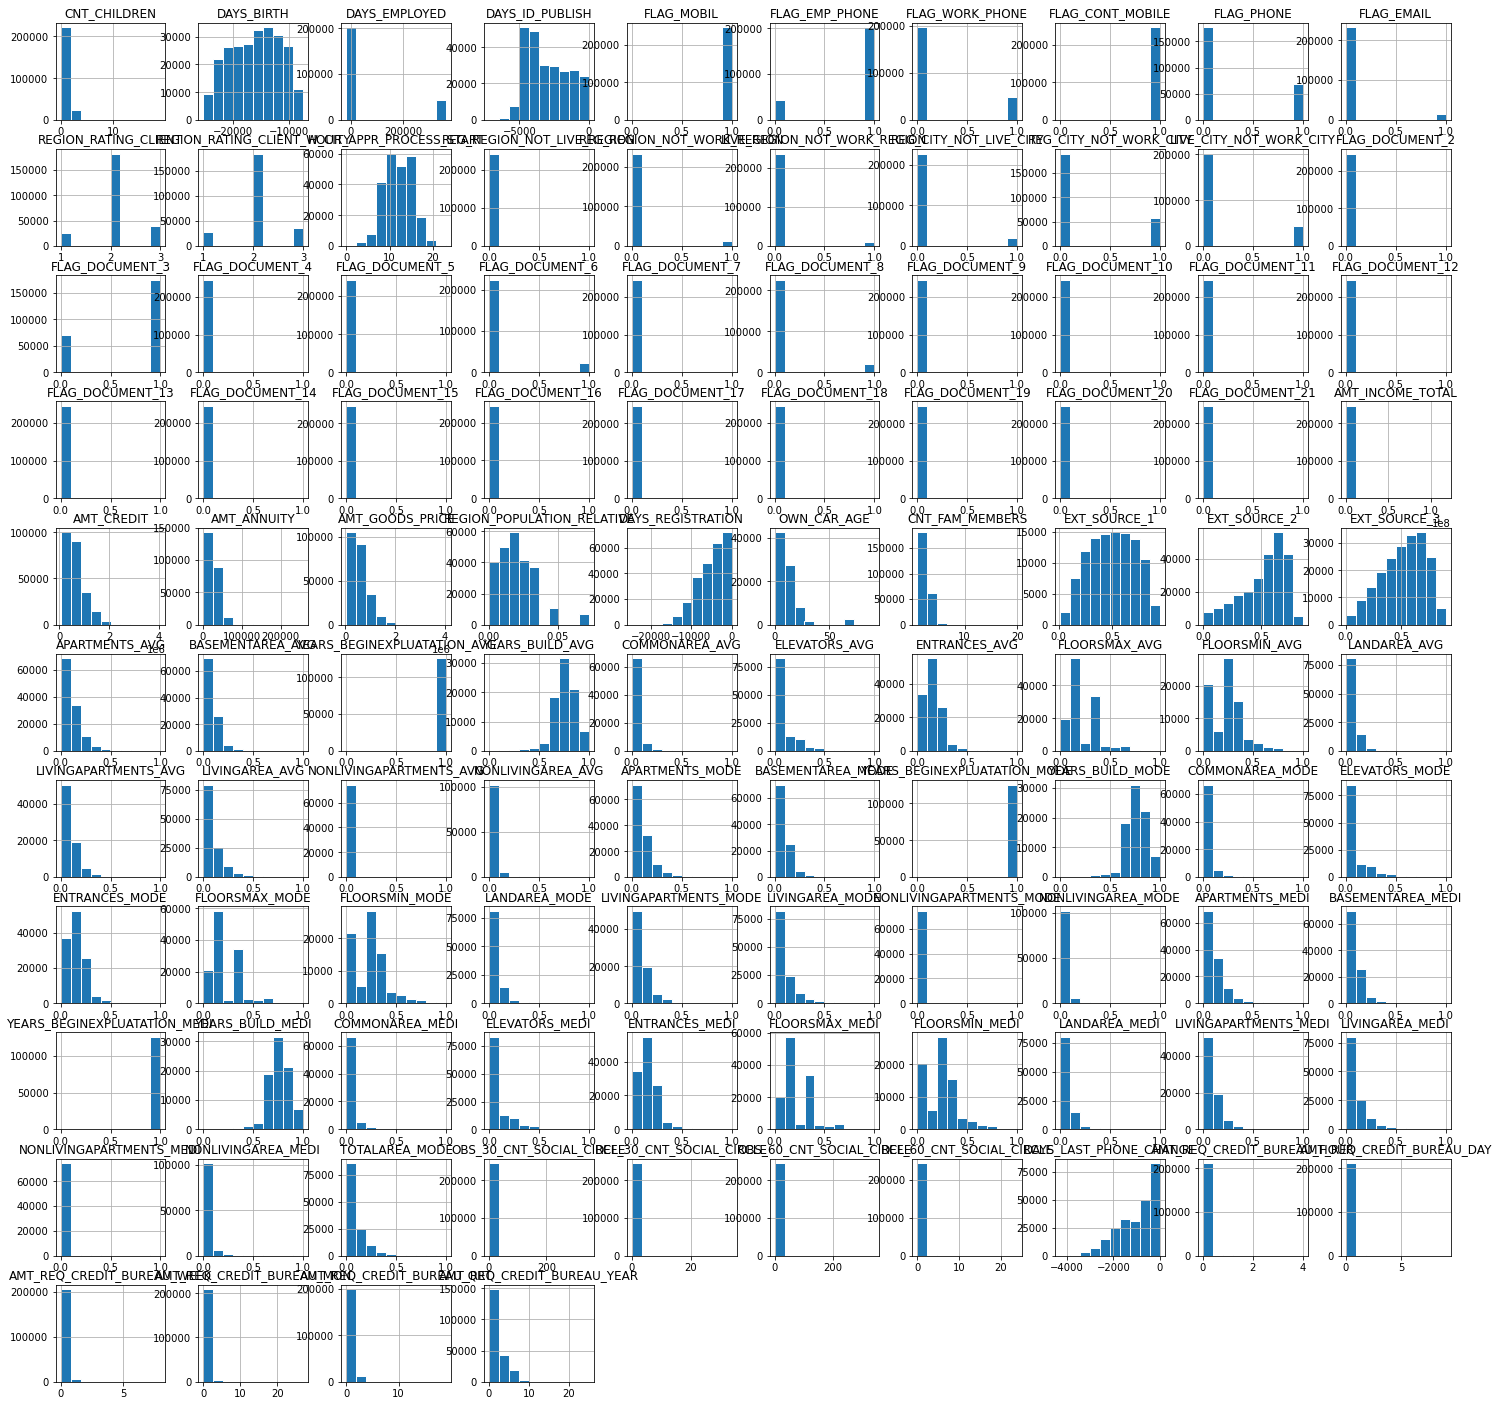

In [62]:
X_train[int_cols+float_cols].hist(figsize=(25,25), ec='w')
plt.show()

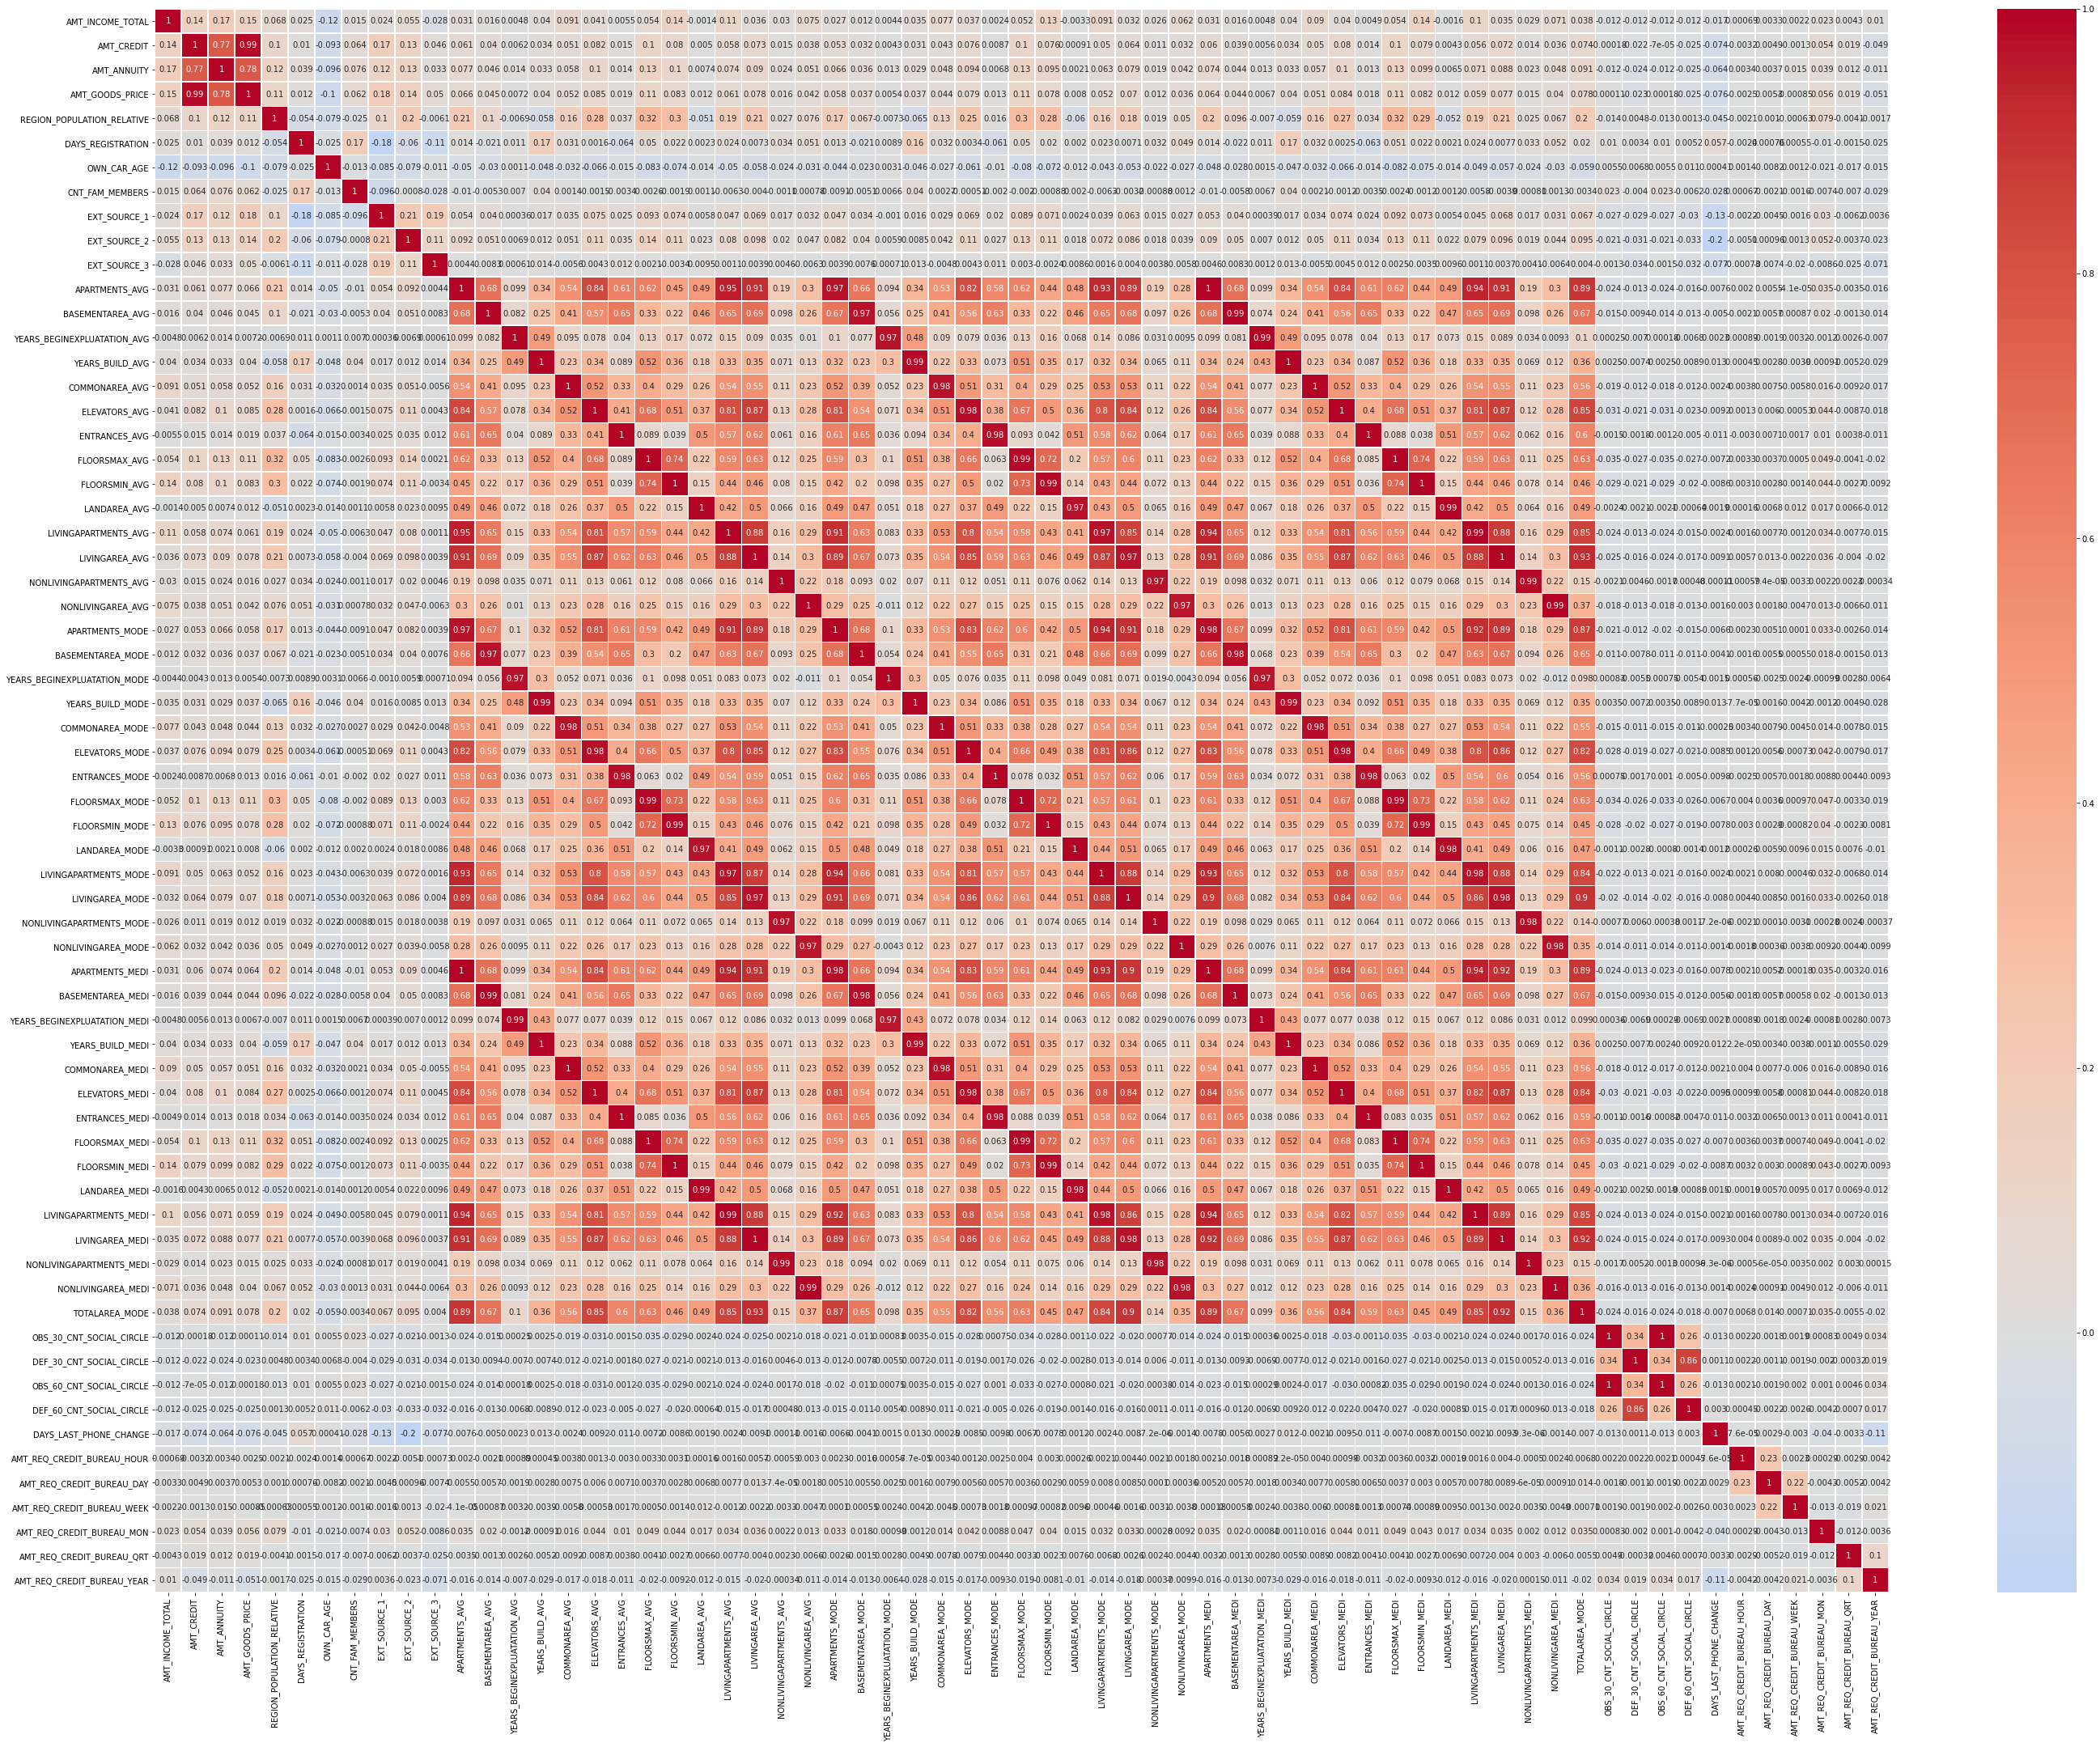

In [63]:
plt.figure(figsize=(48, 36))
sns.heatmap(X_train[float_cols].corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.show()

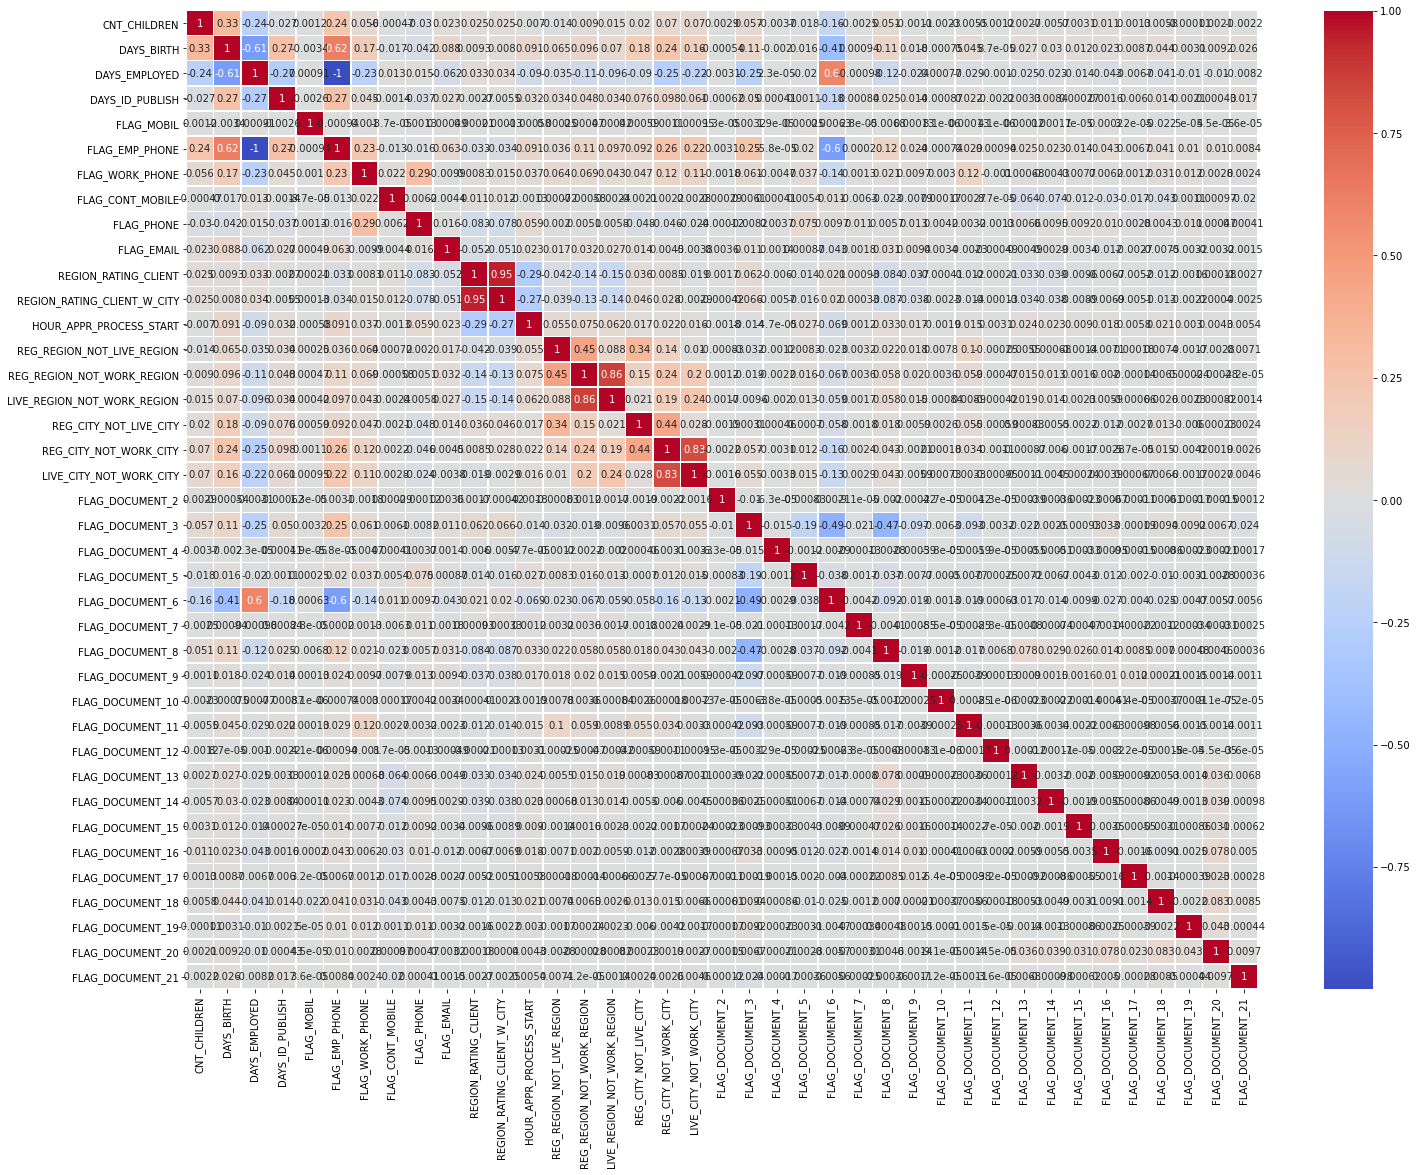

In [64]:
plt.figure(figsize=(24, 18))
sns.heatmap(X_train[int_cols].corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.show()

### Correlation with target

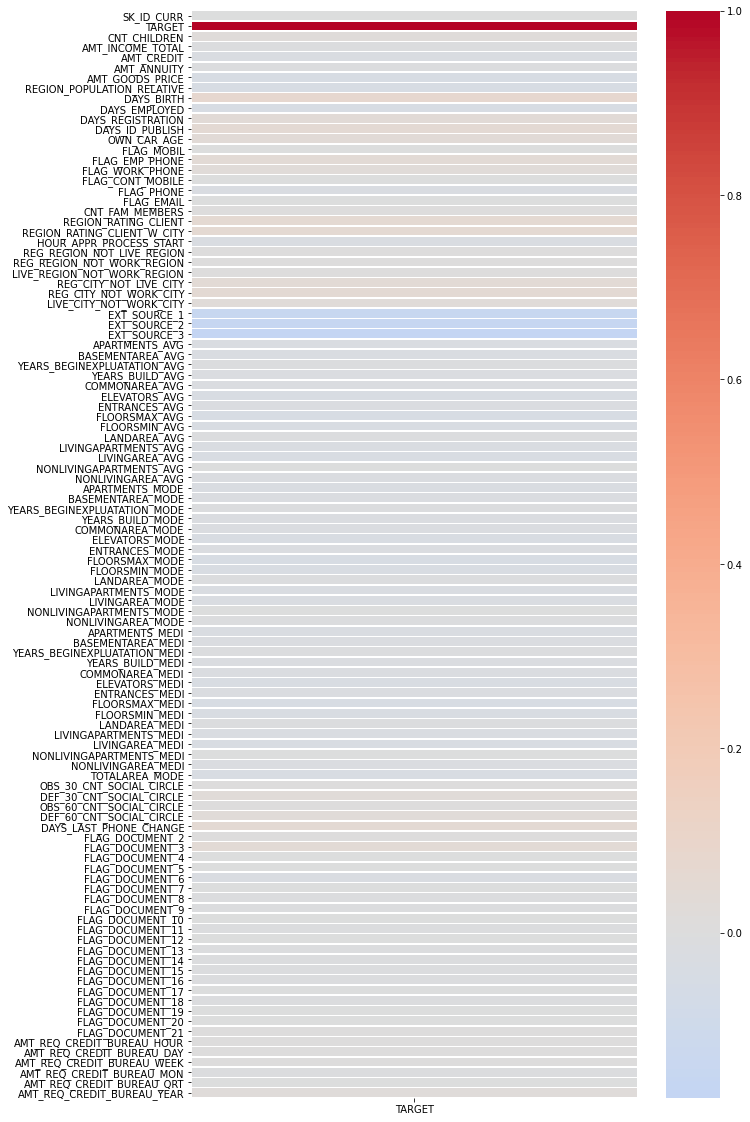

In [65]:
correlations = df.corr()["TARGET"]
correlation_df = pd.DataFrame(correlations)

plt.figure(figsize=(10, 20))
sns.heatmap(correlation_df, cmap='coolwarm', center=0, linewidths=0.5)
plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Converting back to the dataframe 
X_train = np_to_df(X_train, X)
X_test = np_to_df(X_test, X)

# Output the distribution of classes in the original dataset and after the split
print("POSITIVE CLASS PROPORTION")
print("Original data:", round(np.bincount(y)[1]/np.sum(np.bincount(y)),4))
print("Training set:", round(np.bincount(y_train)[1]/np.sum(np.bincount(y_train)),4))
print("Test set:", round(np.bincount(y_test)[1]/np.sum(np.bincount(y_test)),4))

POSITIVE CLASS PROPORTION
Original data: 0.0807
Training set: 0.0807
Test set: 0.0807


- Train and test set have approx same proportion of defaulters.

In [34]:
X_train.shape, X_test.shape

((246008, 120), (61503, 120))

# Data Preprocessing

In [35]:
cat_cols = list(X.select_dtypes('object').columns)
int_cols = list(X.select_dtypes(['int8', 'int16', 'int32']).columns)
float_cols = list(X.select_dtypes(['float16','float32']).columns)
num_cols = int_cols + float_cols

len(cat_cols), len(int_cols), len(float_cols)

(16, 39, 65)

## Handling missing values

In [36]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), num_cols),
        ('cat', SimpleImputer(strategy='constant', fill_value='missing'), cat_cols)
    ],
    remainder='passthrough'
)

In [37]:
X_train = preprocessor.fit_transform(X_train)
X_test= preprocessor.transform(X_test)

X_train = np_to_df(X_train, X)
X_test = np_to_df(X_test, X)

In [38]:
X_train.isna().sum().sum()

0

## Handling categorical features

In [39]:
le = LabelEncoder()
for col in cat_cols:
    # X[col] = le.fit_transform(X[col])
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.fit_transform(X_test[col])

##  Handeling Imbalanced class
 - Over-Sampling using SMOTE

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [23]:
y_train.value_counts()

1    226148
0    226148
Name: TARGET, dtype: int64

# Model Training
- Decision Tree
- AdaBoost


### Decision Tree

In [24]:
# SMOTE 
model = DecisionTreeClassifier(max_depth = 10)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}, Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Train Recall: {recall_score(y_train, y_train_pred):.4f}, Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Train Precision: {precision_score(y_train, y_train_pred):.4f}, Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Train Recall: {f1_score(y_train, y_train_pred):.4f}, Test Recall: {f1_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.8686, Test Accuracy: 0.8604
Train Recall: 0.8172, Test Recall: 0.1764
Train Precision: 0.9109, Test Precision: 0.1630
Train Recall: 0.8615, Test Recall: 0.1694


In [40]:
# Without SMOTE + balanced tree
model = DecisionTreeClassifier(max_depth = 10, class_weight = 'balanced')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}, Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Train Recall: {recall_score(y_train, y_train_pred):.4f}, Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Train Precision: {precision_score(y_train, y_train_pred):.4f}, Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Train Recall: {f1_score(y_train, y_train_pred):.4f}, Test Recall: {f1_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.6679, Test Accuracy: 0.6564
Train Recall: 0.7480, Test Recall: 0.6572
Train Precision: 0.1623, Test Precision: 0.1438
Train Recall: 0.2667, Test Recall: 0.2359


# Adaboost

In [50]:
# Without SMOTE
import time
s = time.time()
model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1, class_weight = 'balanced'), n_estimators = 30)
model.fit(X_train, y_train)
print(time.time()-s)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}, Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Train Recall: {recall_score(y_train, y_train_pred):.4f}, Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Train Precision: {precision_score(y_train, y_train_pred):.4f}, Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Train F1_score: {f1_score(y_train, y_train_pred):.4f}, Test F1_score: {f1_score(y_test, y_test_pred):.4f}")

128.57111430168152
Train Accuracy: 0.6868, Test Accuracy: 0.6885
Train Recall: 0.6698, Test Recall: 0.6687
Train Precision: 0.1588, Test Precision: 0.1593
Train F1_score: 0.2567, Test F1_score: 0.2574


In [53]:
# Without SMOTE, lr = 1.1
import time
s = time.time()
model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1, class_weight = 'balanced'), n_estimators = 8, learning_rate = 1.1)
model.fit(X_train, y_train)
print(time.time()-s)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}, Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Train Recall: {recall_score(y_train, y_train_pred):.4f}, Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Train Precision: {precision_score(y_train, y_train_pred):.4f}, Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Train F1_score: {f1_score(y_train, y_train_pred):.4f}, Test F1_score: {f1_score(y_test, y_test_pred):.4f}")

35.936872243881226
Train Accuracy: 0.6562, Test Accuracy: 0.6586
Train Recall: 0.6682, Test Recall: 0.6622
Train Precision: 0.1454, Test Precision: 0.1454
Train F1_score: 0.2388, Test F1_score: 0.2385


In [35]:
# With SMOTE
import time
s = time.time()
model = AdaBoostClassifier(n_estimators = 1)
model.fit(X_train_resample, y_train_resample)
print(time.time()-s)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}, Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Train Recall: {recall_score(y_train, y_train_pred):.4f}, Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Train Precision: {precision_score(y_train, y_train_pred):.4f}, Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Train Recall: {f1_score(y_train, y_train_pred):.4f}, Test Recall: {f1_score(y_test, y_test_pred):.4f}")

12.383840799331665
Train Accuracy: 0.6400, Test Accuracy: 0.6392
Train Recall: 0.5381, Test Recall: 0.5307
Train Precision: 0.1186, Test Precision: 0.1171
Train Recall: 0.1944, Test Recall: 0.1919


### Best features from decision tree

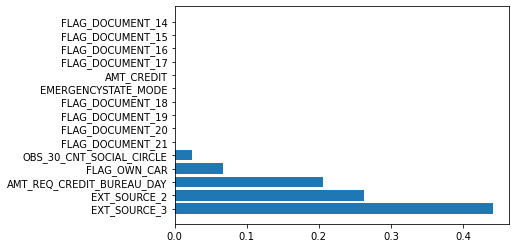

In [41]:
importances = model.feature_importances_
feature_names = X_train_resample.columns
indices = np.argsort(importances)[::-1]
top_indices = indices[:15]

plt.figure(figsize=(6,4))
plt.barh(range(len(top_indices)), importances[top_indices], align="center")
plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
plt.show()

In [45]:
top_20_cols = [feature_names[i] for i in indices[:20]]
top_20_X = X_train_resample[top_20_cols]
X_train, X_test, y_train, y_test = train_test_split(top_20_X, y_train_resample, test_size=0.2, random_state=1)

model = DecisionTreeClassifier(max_depth = 4)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}, Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Train Recall: {recall_score(y_train, y_train_pred):.4f}, Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Train Precision: {precision_score(y_train, y_train_pred):.4f}, Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Train Recall: {f1_score(y_train, y_train_pred):.4f}, Test Recall: {f1_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.7352, Test Accuracy: 0.7326
Train Recall: 0.6976, Test Recall: 0.6917
Train Precision: 0.7540, Test Precision: 0.7541
Train Recall: 0.7247, Test Recall: 0.7215


## Best features form Kbest

In [ ]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit = bestfeatures.fit(X_res,y_res)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_res.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(10,'Score'))  

# Explainability
  - LIME
    - For Local interpretability (explain individual predictions)
    - Why a specific model made a particular prediction?
    - Causal Relationships
  - SHAP
      - It provides both
      - Local interpretability means understanding individual predictions
      - Global interpretability means understanding feature importance
        - Summary Plot: Overview of feature importance and effects.
        - Feature Importance Plot: Rank of feature contributions.
        - Dependence Plot: Impact of a feature across its value range.
        - Force Plot: Individual feature contribution for a single prediction.
        - Waterfall Plot: Breakdown of contributions for a single prediction.
        - Decision Plot: Cumulative contributions for multiple predictions.
        - Bar Plot: Average feature importance.

### LIME

In [40]:
# Create LIME explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=["Non-Defaulter","Defaulter"],
    mode='classification'
)

In [41]:
# Generate LIME explanation
exp = explainer.explain_instance(
    data_row=X_test.iloc[0],
    predict_fn=model.predict_proba, 
    num_features=5)

# Show the explanation
exp.show_in_notebook(show_table=True)

- The above explaination is for a single sample/instance
- This way we can explain, how a prediction for a individual sample has been made and hat are the significat feature affecting it.

### SHAP

In [46]:
explainer = shap.TreeExplainer(model)

In [47]:
shap_values_single = explainer.shap_values(X_train.iloc[0])

In [48]:
# Compute SHAP values for a single instance
shap_values = explainer.shap_values(X_train)

In [49]:
shap_values

[array([[ 0.17111245,  0.01352538,  0.02331642, ...,  0.        ,
          0.        ,  0.        ],
        [-0.116797  , -0.08665808,  0.04113156, ...,  0.        ,
          0.        ,  0.        ],
        [-0.15940295, -0.10924031,  0.04257501, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.116797  , -0.08665808,  0.04113156, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.12220404, -0.12802171,  0.01728711, ...,  0.        ,
          0.        ,  0.        ],
        [-0.116797  , -0.08665808,  0.04113156, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[-0.17111245, -0.01352538, -0.02331642, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.116797  ,  0.08665808, -0.04113156, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.15940295,  0.10924031, -0.04257501, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.116797  ,  0.08665808, -0.04113156, ...,  0.        ,
          0.        ,  0.        ],
        [-0.12220404,  0.12802171, -0.01728711, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.116797  ,  0.08665808, -0.04113156, ...,  0.        ,
          0.        ,  0.        ]])]

### Summary plot
- Provides feature importance

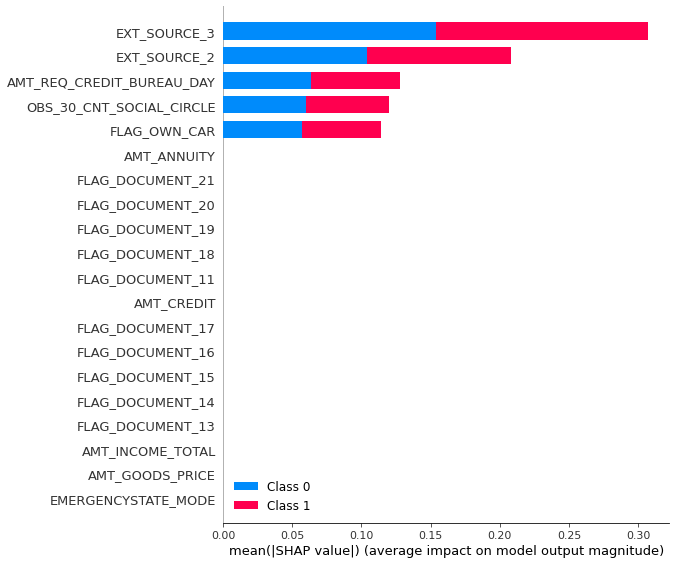

In [50]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

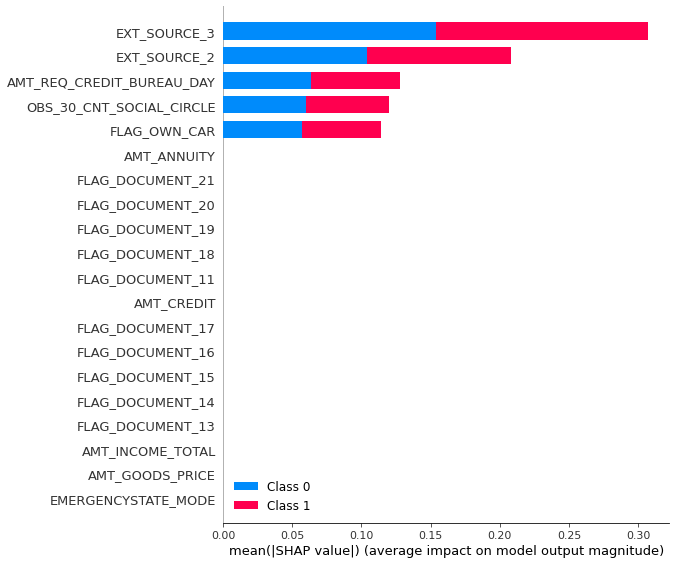

In [53]:
shap.summary_plot(shap_values, X_test, feature_names=top_20_X.columns)

### Dependence Plot
This plot shows the relationship between a feature and the predicted SHAP value while accounting for interaction effects with other features.

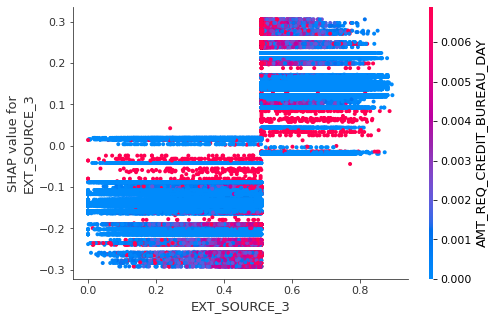

In [51]:
shap.dependence_plot("EXT_SOURCE_3", shap_values[0], X_train)

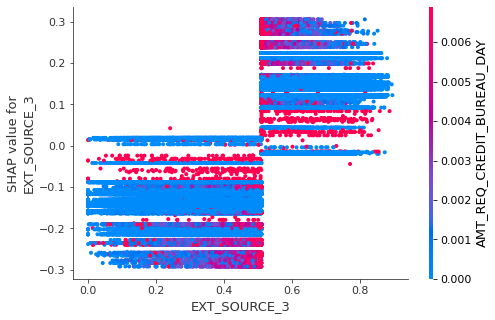

In [55]:
# Dependence plot for a specific feature
shap.dependence_plot(0, shap_values[0], X_train, feature_names=top_20_X.columns)

- higher the Shapley value, higher will be its significance on predictions.